# Practice 08 — Linear Models with Pytorch

Practice 06의 선형 모델(Perceptron 제외)을 **Pytorch**로 재구현합니다.  
수식으로 gradient를 유도할 필요 없이, `loss.backward()` + `optimizer.step()`만으로 학습합니다.

| # | Model | Loss | Activation |
|---|---|---|---|
| 1 | Linear Regression | MSE | — |
| 2 | Logistic (binary) | BCE | sigmoid |
| 3 | Logistic (multi-class) | CrossEntropy | softmax |

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn import datasets

---
# 1. Linear Regression

$$\hat{y} = \mathbf{Xw}, \qquad J = \|\mathbf{Xw} - \mathbf{y}\|^2$$

### 데이터 로드

In [2]:
diabetes = datasets.load_diabetes()
x = diabetes.data[:, 2:3]
y = diabetes.target.reshape(-1, 1)
X = np.hstack([np.ones((len(x), 1)), x])

X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.float32)

print(f'X: {X.shape}, y: {y.shape}')

X: (442, 2), y: (442, 1)


### 학습 파라미터

In [3]:
w = torch.zeros(2, 1, requires_grad=True)
optimizer = torch.optim.SGD([w], lr=0.001)
n_iter = 3000

### 학습

In [4]:
loss_hist = []

for i in range(n_iter):
    loss = ((X_t @ w - y_t)**2).sum()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_hist.append(loss.item())

print(f'w = {w.detach().numpy().flatten()}')

w = [152.13348 947.0957 ]


### 시각화

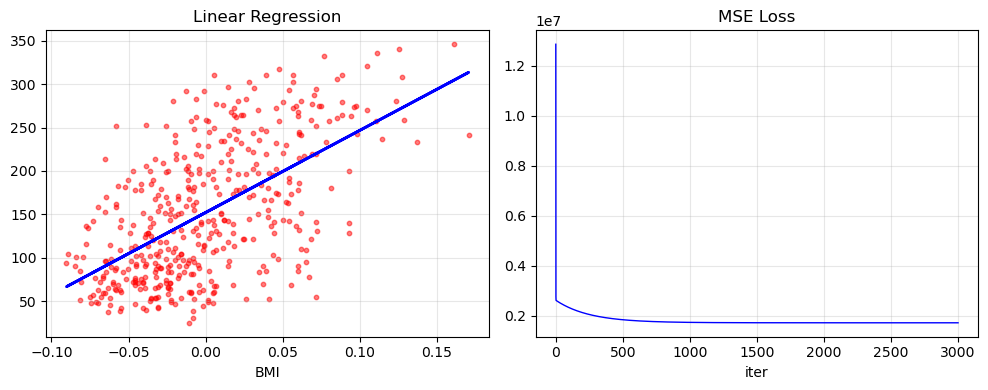

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x, y, c='r', s=10, alpha=0.5)
axes[0].plot(x, (X_t @ w).detach().numpy(), 'b-', lw=2)
axes[0].set_title('Linear Regression'); axes[0].set_xlabel('BMI'); axes[0].grid(alpha=0.3)
axes[1].plot(loss_hist, 'b-', lw=1)
axes[1].set_title('MSE Loss'); axes[1].set_xlabel('iter'); axes[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()

---
# 2. Logistic Regression (Binary)

$$\hat{y} = \sigma(\mathbf{Xw}), \qquad J = -\sum \bigl[ y \log \hat{y} + (1-y) \log(1-\hat{y}) \bigr]$$

### 데이터 로드

In [6]:
iris = datasets.load_iris()
mask = iris.target < 2
X_raw = iris.data[mask, :2]
y_cls = iris.target[mask].astype(float)

X_cls = np.column_stack([np.ones(len(y_cls)), X_raw])

X_t = torch.tensor(X_cls, dtype=torch.float32)
y_t = torch.tensor(y_cls, dtype=torch.float32)

print(f'X: {X_cls.shape}, classes: {np.unique(y_cls)}')

X: (100, 3), classes: [0. 1.]


### 학습 파라미터

In [7]:
w = torch.zeros(3, requires_grad=True)
optimizer = torch.optim.SGD([w], lr=0.01)
n_epochs = 200

### 학습

In [8]:
loss_hist = []

for ep in range(n_epochs):
    o = torch.sigmoid(X_t @ w)
    loss = -(y_t * torch.log(o + 1e-15) + (1 - y_t) * torch.log(1 - o + 1e-15)).sum()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_hist.append(loss.item())

print(f'w = {w.detach().numpy().round(3)}')
print(f'Loss: {loss_hist[0]:.2f} → {loss_hist[-1]:.2f}')

w = [ -1.321   6.147 -10.333]
Loss: 69.31 → 4.96


### 시각화

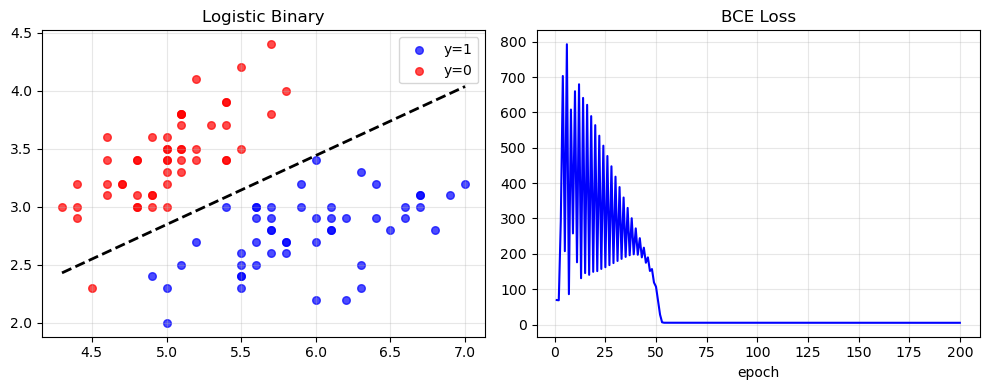

In [9]:
w_np = w.detach().numpy()
pos, neg = y_cls == 1, y_cls == 0

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(X_raw[pos, 0], X_raw[pos, 1], c='b', s=30, label='y=1', alpha=0.7)
axes[0].scatter(X_raw[neg, 0], X_raw[neg, 1], c='r', s=30, label='y=0', alpha=0.7)
x1 = np.linspace(X_raw[:, 0].min(), X_raw[:, 0].max(), 100)
x2 = -(w_np[0] + w_np[1] * x1) / w_np[2]
axes[0].plot(x1, x2, 'k--', lw=2)
axes[0].set_title('Logistic Binary'); axes[0].legend(); axes[0].grid(alpha=0.3)
axes[1].plot(range(1, n_epochs + 1), loss_hist, 'b-', lw=1.5)
axes[1].set_title('BCE Loss'); axes[1].set_xlabel('epoch'); axes[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()

### 학습 (torch Loss 사용)

`nn.BCEWithLogitsLoss`는 **sigmoid + BCE**를 내부에서 한번에 처리합니다.  
수동으로 `torch.sigmoid`와 `torch.log`를 호출할 필요가 없습니다.

In [10]:
# --- 데이터 재사용 (sec2-data 셀과 동일) ---
X_t = torch.tensor(X_cls, dtype=torch.float32)
y_t = torch.tensor(y_cls, dtype=torch.float32)

# --- 파라미터 초기화 ---
w_torch = torch.zeros(3, requires_grad=True)
optimizer = torch.optim.SGD([w_torch], lr=0.01)
criterion = nn.BCEWithLogitsLoss(reduction='sum')
n_epochs = 200

# --- 학습 ---
loss_hist_torch = []

for ep in range(n_epochs):
    z = X_t @ w_torch                  # logit (sigmoid 적용 전)
    loss = criterion(z, y_t)           # sigmoid + BCE를 내부에서 처리
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_hist_torch.append(loss.item())

print(f'w = {w_torch.detach().numpy().round(3)}')
print(f'Loss: {loss_hist_torch[0]:.2f} → {loss_hist_torch[-1]:.2f}')

w = [ -1.317   6.146 -10.333]
Loss: 69.31 → 4.96


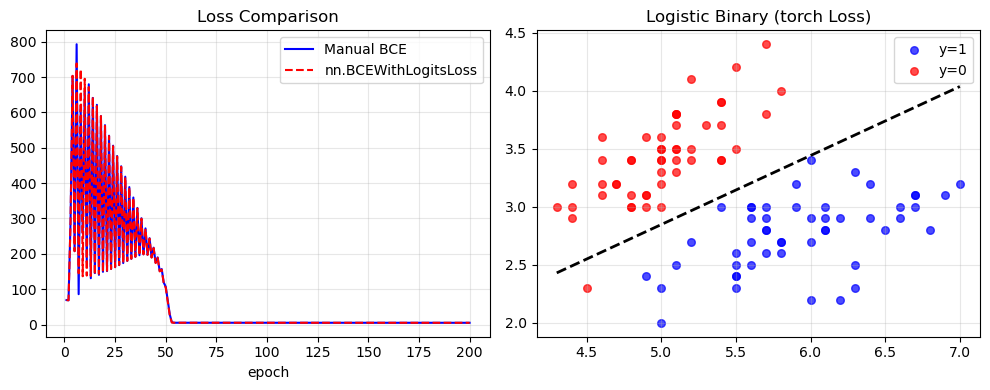

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(range(1, n_epochs + 1), loss_hist, 'b-', lw=1.5, label='Manual BCE')
axes[0].plot(range(1, n_epochs + 1), loss_hist_torch, 'r--', lw=1.5, label='nn.BCEWithLogitsLoss')
axes[0].set_title('Loss Comparison'); axes[0].set_xlabel('epoch'); axes[0].legend(); axes[0].grid(alpha=0.3)

w_np = w_torch.detach().numpy()
axes[1].scatter(X_raw[pos, 0], X_raw[pos, 1], c='b', s=30, label='y=1', alpha=0.7)
axes[1].scatter(X_raw[neg, 0], X_raw[neg, 1], c='r', s=30, label='y=0', alpha=0.7)
x1 = np.linspace(X_raw[:, 0].min(), X_raw[:, 0].max(), 100)
x2 = -(w_np[0] + w_np[1] * x1) / w_np[2]
axes[1].plot(x1, x2, 'k--', lw=2)
axes[1].set_title('Logistic Binary (torch Loss)'); axes[1].legend(); axes[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()

### Loss Comparison: BCELoss vs BCEWithLogitsLoss

| Loss | Input | Sigmoid |
|---|---|---|
| `nn.BCELoss` | 확률값 $\hat{y} = \sigma(z)$ | **수동** 적용 |
| `nn.BCEWithLogitsLoss` | logit $z$ | **내부** 적용 |

둘 다 동일한 BCE를 계산합니다: $-\bigl[y\log\hat{y} + (1-y)\log(1-\hat{y})\bigr]$

In [12]:
# 동일한 학습된 가중치로 세 가지 loss 값 비교
with torch.no_grad():
    z     = X_t @ w_torch                          # logit (원시 점수)
    y_hat = torch.sigmoid(z)                        # 확률값

    # 1) 수동 BCE
    loss_manual = -(y_t * torch.log(y_hat + 1e-15)
                    + (1 - y_t) * torch.log(1 - y_hat + 1e-15)).sum()

    # 2) nn.BCELoss — 입력: 확률값 (sigmoid 적용 후)
    loss_bce = nn.BCELoss(reduction='sum')(y_hat, y_t)

    # 3) nn.BCEWithLogitsLoss — 입력: logit (sigmoid 적용 전)
    loss_bce_logits = nn.BCEWithLogitsLoss(reduction='sum')(z, y_t)

print('=== Binary Loss Comparison (same weights) ===')
print(f'  Manual BCE:            {loss_manual.item():.4f}')
print(f'  nn.BCELoss:            {loss_bce.item():.4f}')
print(f'  nn.BCEWithLogitsLoss:  {loss_bce_logits.item():.4f}')

=== Binary Loss Comparison (same weights) ===
  Manual BCE:            4.9563
  nn.BCELoss:            4.9563
  nn.BCEWithLogitsLoss:  4.9563


---
# 3. Logistic Regression (Multi-class)

$$o_k = \text{softmax}(z_k), \qquad J = -\sum_n \log o_{n,y_n}$$

### 데이터 로드

In [13]:
iris = datasets.load_iris()
X_raw_mc = iris.data
y_mc = iris.target
N, C, d = len(y_mc), 3, 4

X_mc = np.column_stack([np.ones(N), X_raw_mc])

X_t = torch.tensor(X_mc, dtype=torch.float32)
y_t = torch.tensor(y_mc, dtype=torch.long)

print(f'X: {X_mc.shape}, classes: {np.unique(y_mc)}')

X: (150, 5), classes: [0 1 2]


### 학습 파라미터

In [14]:
W = torch.zeros(C, d + 1, requires_grad=True)
optimizer = torch.optim.SGD([W], lr=0.001)
n_epochs = 300

### 학습

In [15]:
loss_hist, acc_hist = [], []

for ep in range(n_epochs):
    logits = X_t @ W.T                        # (N, C) — 클래스별 점수(logit)
    loss = torch.nn.functional.cross_entropy(logits, y_t, reduction='sum')
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # argmax(dim=1): 각 샘플에서 가장 높은 점수를 가진 클래스 인덱스를 선택
    pred = logits.argmax(dim=1)                # (N,) — 예측 클래스 인덱스
    acc = (pred == y_t).float().mean().item()
    loss_hist.append(loss.item())
    acc_hist.append(acc)

print(f'Loss: {loss_hist[0]:.2f} → {loss_hist[-1]:.2f}')
print(f'Accuracy: {acc_hist[0]:.1%} → {acc_hist[-1]:.1%}')

Loss: 164.79 → 23.49
Accuracy: 33.3% → 98.0%


### Why `argmax`?

모델은 샘플당 **C개의 점수**(logits)를 출력합니다.  
`argmax(dim=1)`은 각 샘플에서 **가장 높은 점수를 가진 클래스 인덱스**를 예측값으로 선택합니다.

In [16]:
with torch.no_grad():
    logits = X_t @ W.T                             # (150, 3)
    probs  = torch.softmax(logits, dim=1)

# 한 샘플을 단계별로 확인
print('=== argmax Step-by-Step ===')
print(f'logits shape: {logits.shape}  — (N_samples, N_classes)\n')
print(f'Sample 0 logits : {logits[0].numpy().round(3)}')
print(f'Sample 0 softmax: {probs[0].numpy().round(3)}')
print(f'argmax → class  : {logits[0].argmax().item()}')
print(f'true label      : {y_t[0].item()}')
print(f'\nFirst 10 predictions: {logits[:10].argmax(dim=1).numpy()}')
print(f'First 10 labels    : {y_t[:10].numpy()}')

=== argmax Step-by-Step ===
logits shape: torch.Size([150, 3])  — (N_samples, N_classes)

Sample 0 logits : [ 6.608  2.672 -9.28 ]
Sample 0 softmax: [0.981 0.019 0.   ]
argmax → class  : 0
true label      : 0

First 10 predictions: [0 0 0 0 0 0 0 0 0 0]
First 10 labels    : [0 0 0 0 0 0 0 0 0 0]


### Training with NLLLoss

| Loss | Input | Softmax |
|---|---|---|
| `nn.NLLLoss` | log-확률 `log_softmax(z)` | **수동** 적용 |
| `nn.CrossEntropyLoss` | logit $z$ | **내부** 적용 |

둘 다 동일한 CE를 계산합니다: $-\log \dfrac{e^{z_k}}{\sum_j e^{z_j}}$

In [17]:
W_nll = torch.zeros(C, d + 1, requires_grad=True)
optimizer_nll = torch.optim.SGD([W_nll], lr=0.001)
criterion_nll = nn.NLLLoss(reduction='sum')

loss_hist_nll, acc_hist_nll = [], []

for ep in range(n_epochs):
    logits    = X_t @ W_nll.T
    log_probs = torch.log_softmax(logits, dim=1)   # NLLLoss는 log-확률을 입력으로 받음
    loss = criterion_nll(log_probs, y_t)
    loss.backward()
    optimizer_nll.step()
    optimizer_nll.zero_grad()

    pred = logits.argmax(dim=1)
    acc = (pred == y_t).float().mean().item()
    loss_hist_nll.append(loss.item())
    acc_hist_nll.append(acc)

print(f'Loss: {loss_hist_nll[0]:.2f} → {loss_hist_nll[-1]:.2f}')
print(f'Accuracy: {acc_hist_nll[0]:.1%} → {acc_hist_nll[-1]:.1%}')

Loss: 164.79 → 23.49
Accuracy: 33.3% → 98.0%


### Loss Comparison: CrossEntropyLoss vs NLLLoss

In [18]:
# 동일한 가중치로 두 loss 값 비교
with torch.no_grad():
    logits = X_t @ W.T

    # CrossEntropyLoss — 입력: logits (softmax 내부 적용)
    loss_ce = nn.CrossEntropyLoss(reduction='sum')(logits, y_t)

    # NLLLoss — 입력: log_softmax (softmax 수동 적용)
    log_probs = torch.log_softmax(logits, dim=1)
    loss_nll = nn.NLLLoss(reduction='sum')(log_probs, y_t)

print('=== Multi-class Loss Comparison (same weights) ===')
print(f'  nn.CrossEntropyLoss:  {loss_ce.item():.4f}')
print(f'  nn.NLLLoss:           {loss_nll.item():.4f}')

=== Multi-class Loss Comparison (same weights) ===
  nn.CrossEntropyLoss:  23.4642
  nn.NLLLoss:           23.4642


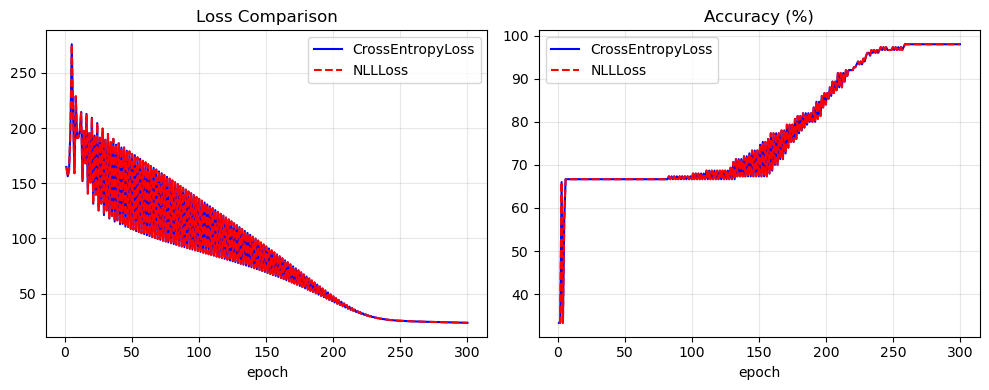

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(range(1, n_epochs+1), loss_hist, 'b-', lw=1.5, label='CrossEntropyLoss')
axes[0].plot(range(1, n_epochs+1), loss_hist_nll, 'r--', lw=1.5, label='NLLLoss')
axes[0].set_title('Loss Comparison'); axes[0].set_xlabel('epoch'); axes[0].legend(); axes[0].grid(alpha=0.3)
axes[1].plot(range(1, n_epochs+1), [a*100 for a in acc_hist], 'b-', lw=1.5, label='CrossEntropyLoss')
axes[1].plot(range(1, n_epochs+1), [a*100 for a in acc_hist_nll], 'r--', lw=1.5, label='NLLLoss')
axes[1].set_title('Accuracy (%)'); axes[1].set_xlabel('epoch'); axes[1].legend(); axes[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()

### 시각화

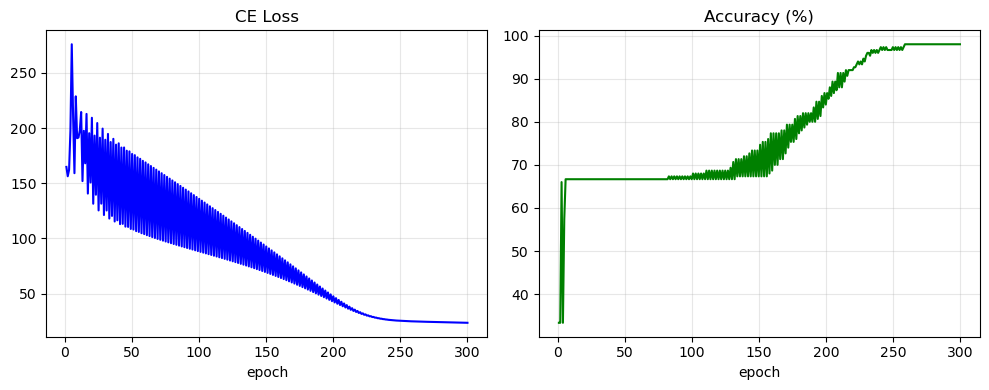

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(range(1, n_epochs + 1), loss_hist, 'b-', lw=1.5)
axes[0].set_title('CE Loss'); axes[0].set_xlabel('epoch'); axes[0].grid(alpha=0.3)
axes[1].plot(range(1, n_epochs + 1), [a * 100 for a in acc_hist], 'g-', lw=1.5)
axes[1].set_title('Accuracy (%)'); axes[1].set_xlabel('epoch'); axes[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()

---
# 4. nn.Module 활용

`nn.Linear`를 사용하면 가중치 정의와 forward를 더 간결하게 작성할 수 있습니다.

### Binary Classification (nn.Module)

In [21]:
iris = datasets.load_iris()
mask = iris.target < 2

X_t = torch.tensor(iris.data[mask, :2], dtype=torch.float32)
y_t = torch.tensor(iris.target[mask], dtype=torch.float32).view(-1, 1)

model = nn.Linear(2, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1000):
    loss = criterion(model(X_t), y_t)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

with torch.no_grad():
    pred = (torch.sigmoid(model(X_t)) >= 0.5).int().flatten()
    acc = (pred == y_t.int().flatten()).float().mean()
print(f'Accuracy: {acc:.1%}')

Accuracy: 99.0%


### Multi-class Classification (nn.Module)

In [22]:
X_t = torch.tensor(iris.data, dtype=torch.float32)
y_t = torch.tensor(iris.target, dtype=torch.long)

model = nn.Linear(4, 3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(500):
    loss = criterion(model(X_t), y_t)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

with torch.no_grad():
    acc = (model(X_t).argmax(dim=1) == y_t).float().mean()
print(f'Accuracy: {acc:.1%}')

Accuracy: 98.0%


### `class`로 모델 정의하기

위 예시에서는 `nn.Linear`를 직접 사용했지만, 모델이 복잡해지면 **클래스로 정의**하는 것이 표준 패턴입니다.

```python
class ModelName(nn.Module):          # nn.Module을 상속
    def __init__(self, ...):         # 레이어(학습 파라미터) 정의
        super().__init__()           # nn.Module 초기화 (필수)
        self.layer = nn.Linear(...)

    def forward(self, x):            # 순전파 계산 정의
        return self.layer(x)
```

| 구성요소 | 역할 |
|---|---|
| `nn.Module` 상속 | 파라미터 추적, gradient 계산 등 PyTorch 기능 활용 |
| `__init__` | `nn.Linear` 등 학습 가능한 레이어를 `self` 속성으로 등록 |
| `super().__init__()` | `nn.Module` 초기화 — **없으면 파라미터 추적 불가** |
| `forward(x)` | 입력 `x`에서 출력까지의 계산 과정을 정의 |
| `model(x)` | 내부적으로 `model.forward(x)` 실행 (직접 `.forward()` 호출하지 않음) |

In [23]:
# --- Binary Classification ---

class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()                          # nn.Module 초기화 (필수)
        self.linear = nn.Linear(input_dim, 1)       # 학습 가능한 레이어 등록

    def forward(self, x):                           # 순전파: model(x) 호출 시 실행
        return self.linear(x)                       # logit 반환 (sigmoid는 loss에서 처리)

# 모델 구조 확인
model = BinaryClassifier(input_dim=2)
print(model)
print(f'\n학습 가능한 파라미터:')
for name, param in model.named_parameters():
    print(f'  {name}: {param.shape}')

BinaryClassifier(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)

학습 가능한 파라미터:
  linear.weight: torch.Size([1, 2])
  linear.bias: torch.Size([1])


In [24]:
# 학습
iris = datasets.load_iris()
mask = iris.target < 2

X_t = torch.tensor(iris.data[mask, :2], dtype=torch.float32)
y_t = torch.tensor(iris.target[mask], dtype=torch.float32).view(-1, 1)

model = BinaryClassifier(input_dim=2)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # model.parameters()로 모든 가중치 전달

for epoch in range(1000):
    loss = criterion(model(X_t), y_t)   # model(X_t) → forward(X_t) 자동 호출
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

with torch.no_grad():
    pred = (torch.sigmoid(model(X_t)) >= 0.5).int().flatten()
    acc = (pred == y_t.int().flatten()).float().mean()
print(f'Accuracy: {acc:.1%}')

Accuracy: 99.0%


In [25]:
# --- Multi-class Classification ---

class MultiClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)                       # logits 반환 (softmax는 loss에서 처리)

# 모델 구조 확인
model = MultiClassifier(input_dim=4, num_classes=3)
print(model)
print(f'\n학습 가능한 파라미터:')
for name, param in model.named_parameters():
    print(f'  {name}: {param.shape}')

MultiClassifier(
  (linear): Linear(in_features=4, out_features=3, bias=True)
)

학습 가능한 파라미터:
  linear.weight: torch.Size([3, 4])
  linear.bias: torch.Size([3])


In [26]:
# 학습
X_t = torch.tensor(iris.data, dtype=torch.float32)
y_t = torch.tensor(iris.target, dtype=torch.long)

model = MultiClassifier(input_dim=4, num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(500):
    loss = criterion(model(X_t), y_t)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

with torch.no_grad():
    acc = (model(X_t).argmax(dim=1) == y_t).float().mean()
print(f'Accuracy: {acc:.1%}')

Accuracy: 96.7%


### `model(x)` 호출 구조

```
model(X_t)
  → nn.Module.__call__(X_t)        # 내부에서 hook 처리, gradient 추적 등 수행
    → model.forward(X_t)           # 우리가 정의한 forward 실행
      → self.linear(X_t)           # nn.Linear: X @ W.T + b
```

> **주의:** `model.forward(x)`를 직접 호출하지 않고 반드시 **`model(x)`** 로 호출합니다.  
> `__call__`이 gradient 추적, hook 실행 등을 처리하기 때문입니다.

### class를 쓰는 이유

| `nn.Linear` 직접 사용 | `class` 정의 |
|---|---|
| 레이어 1개일 때 간편 | 여러 레이어 조합 가능 |
| forward 로직 없음 | `forward`에서 자유롭게 계산 정의 |
| 재사용 어려움 | 클래스로 재사용·확장 용이 |

다음 강의(Deep Learning)에서 레이어를 여러 개 쌓을 때 이 패턴이 필수가 됩니다.

---
# 5. 비교 요약

| | Practice 06 (numpy) | Practice 08 (pytorch) |
|---|---|---|
| **Gradient** | 수식 유도 필요 | `loss.backward()` |
| **Update** | `w -= alpha * dJ` | `optimizer.step()` |
| **Sigmoid** | 직접 구현 | `torch.sigmoid()` |
| **Softmax + CE** | 직접 구현 | `F.cross_entropy()` |
| **모델 정의** | 행렬 연산 직접 작성 | `nn.Linear(in, out)` |